## DCL CoCo Bonds

The following code imports data exported from Reuters, then uses it to model DCL CoCo bonds. 

In [1]:
"""
TODO: Add AT1 bond data
TODO: Add CET1 ratio data
TODO: Add shares outstanding data (NS_{k-1})

TODO: Find risk free rates (Yield curve?)
TODO: Derive the following from the data:
    RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m})) # Note that this only applies if the triggers are not breached
    Leverage ratio = Total debt / (Total equity + Total debt) = RQ_k / (RQ_k + NS_{k-1} * S_k)
    alpha = RQ_k / (RQ_k + Book value of non CoCo debt)
"""

'\nTODO: Add AT1 bond data\nTODO: Add CET1 ratio data\nTODO: Add shares outstanding data (NS_{k-1})\n\nTODO: Find risk free rates (Yield curve?)\nTODO: Derive the following from the data:\n    RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m})) # Note that this only applies if the triggers are not breached\n    Leverage ratio = Total debt / (Total equity + Total debt) = RQ_k / (RQ_k + NS_{k-1} * S_k)\n    alpha = RQ_k / (RQ_k + Book value of non CoCo debt)\n'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf  # Cufflinks
import configparser as cp
import warnings

# Remove Eikon API depreciation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# ================================================================
#                         Model Parameters
# ================================================================

ticker = "CSGN.S"   # Credit Suisse
# ticker = "DBKGn.DE" # Deutsche Bank
# ticker = "LEHMQ.PK" # Lehman Brothers
# ticker = "SVBQ.PK"  # Silicon Valley Bank

T = 10       # Number of years to maturity for DCL bonds
r = 0.05     # Risk free rate
L_min = 0.20 # Minimum leverage ratio
L_c = 0.8    # Critical leverage ratio


In [ ]:
# ================================================================
#                     Load data from Reuters
# ================================================================

def load_timeseries_data(data_folder = "data") -> pd.DataFrame: 
    """
    Load timeseries data from Reuters
    """

    close_df              = pd.read_excel(f'{data_folder}/cs_close.xlsx', index_col = 0, parse_dates = True)
    shares_outstanding_df = pd.read_excel(f'{data_folder}/cs_shares_outstanding.xlsx', index_col = 0, parse_dates = True)
    market_cap_df         = pd.read_excel(f'{data_folder}/cs_market_cap.xlsx', index_col = 0, parse_dates = True)
    total_assets_df       = pd.read_excel(f'{data_folder}/cs_total_assets.xlsx', index_col = 0, parse_dates = True)
    total_debt_df         = pd.read_excel(f'{data_folder}/cs_total_debt.xlsx', index_col = 0, parse_dates = True)
    # at1_debt_df           = pd.read_excel(f'{data_folder}/cs_at1_debt.xlsx', index_col = 0, parse_dates = True)

    # Drop duplicates
    close_df              = close_df[~close_df.index.duplicated(keep='first')]
    shares_outstanding_df = shares_outstanding_df[~shares_outstanding_df.index.duplicated(keep='first')]
    market_cap_df         = market_cap_df[~market_cap_df.index.duplicated(keep='first')]
    total_assets_df       = total_assets_df[~total_assets_df.index.duplicated(keep='first')]
    total_debt_df         = total_debt_df[~total_debt_df.index.duplicated(keep='first')]
    # at1_debt_df           = at1_debt_df[~at1_debt_df.index.duplicated(keep='first')]

    # Fill business days inbetween
    full_range = pd.date_range(
        start=close_df.index.min(),
        end=close_df.index.max(),
        # freq='B'
    )
    # 2. Reindex each DataFrame to that full range, then ffill
    close_df = close_df.reindex(full_range).ffill()
    shares_outstanding_df = shares_outstanding_df.reindex(full_range).ffill()
    market_cap_df = market_cap_df.reindex(full_range).ffill()
    total_assets_df = total_assets_df.reindex(full_range).ffill()
    total_debt_df = total_debt_df.reindex(full_range).ffill()
    # at1_debt_df = at1_debt_df.reindex(full_range).ffill()
    # TODO: Remove non-business days

    # print(close_df)
    # print(shares_outstanding_df)
    # print(market_cap_df)
    # print(total_assets_df)
    # print(total_debt_df)
    # print(at1_debt_df)

    input_data = close_df.merge(shares_outstanding_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(market_cap_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_assets_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_debt_df, left_index=True, right_index=True, how='left')
    # input_data = input_data.merge(at1_debt_df, left_index=True, right_index=True, how='left')

    return input_data

# # Shares outstanding from book value data:
# shares_outstanding = {
#     "2018": 2_550_600_000, 
#     "2019": 2_436_200_000, 
#     "2020": 2_406_144_879, 
#     "2021": 2_569_684_509, 
#     "2022": 3_941_250_081
# }

input_data = load_timeseries_data()

# input_data["Calculated market cap"] = input_data["Close"] * input_data["Common Shares - Outstanding - Total"]
# input_data[["Calculated market cap", "Company Market Cap"]].plot()


# input_data.plot()
input_data


,Close,Common Shares - Outstanding - Total,Company Market Capitalization,Total Assets,Total Debt
2018-01-03,16.630954,NaN,4.744485e+10,NaN,NaN
2018-01-04,16.877058,NaN,4.814694e+10,NaN,NaN
2018-01-05,16.697213,NaN,4.763387e+10,NaN,NaN
2018-01-06,16.697213,NaN,4.763387e+10,NaN,NaN
2018-01-07,16.697213,NaN,4.763387e+10,NaN,NaN
...,...,...,...,...,...
2023-06-08,0.811000,3.941250e+09,3.245750e+09,5.313580e+11,1.929070e+11
2023-06-09,0.808000,3.941250e+09,3.233744e+09,5.313580e+11,1.929070e+11
2023-06-10,0.808000,3.941250e+09,3.233744e+09,5.313580e+11,1.929070e+11
2023-06-11,0.808000,3.941250e+09,3.233744e+09,5.313580e+11,1.929070e+11


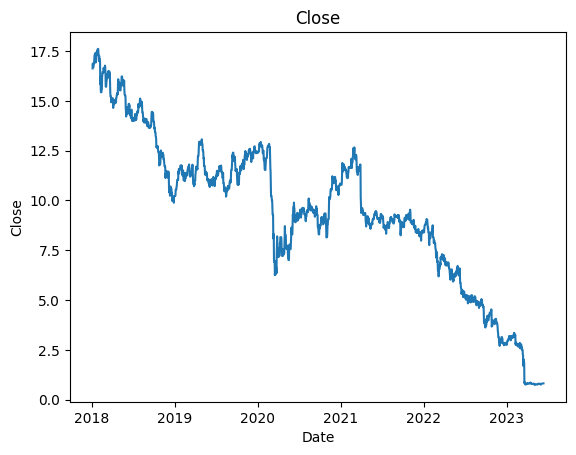

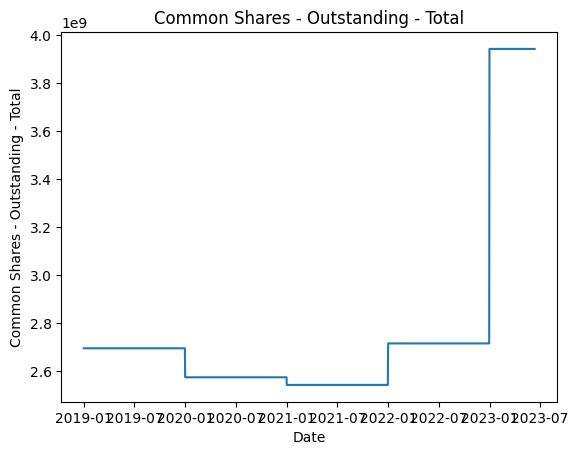

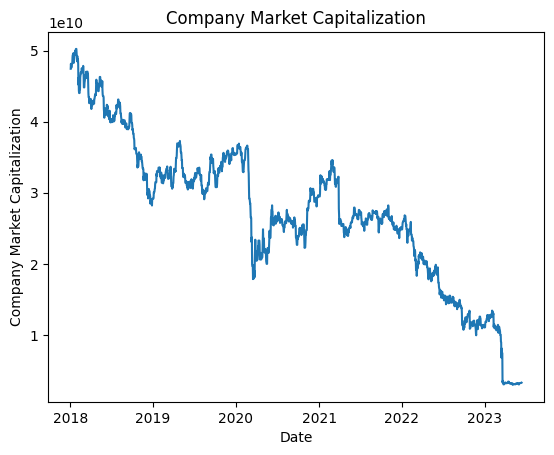

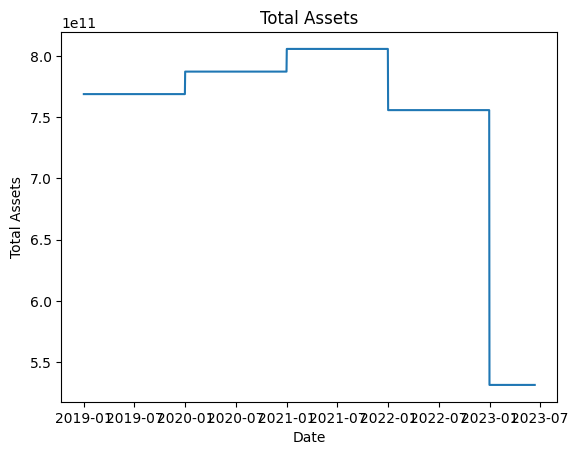

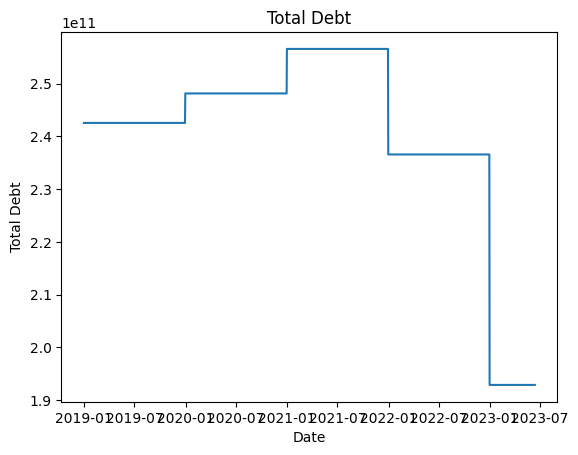

In [4]:
# ================================================================
#                        Plot the data
# ================================================================

def plot_input_data(stock_data: pd.DataFrame) -> None:
    """
    Plot the stock data. 
    """

    for col in input_data.columns:
        plt.figure()
        plt.plot(input_data.index, input_data[col])
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)

    plt.show()

plot_input_data(input_data)


In [ ]:
# ================================================================
#                    Calculate dependent variables
# ================================================================

def calculate_residual_value_of_dcl(Q, r, N_m, k):
    """
    Calculate the residual value of DCL bond at time k. 
    """

    return Q * ((1 + r)**k + (1 - (1 + r)**k)/(1 - (1 + r)**(-N_m)))

def calculate_alpha(RQ_k, book_value_of_non_coco_debt):
    """
    Calculate the ratio of CoCos to total debt. 
    """
    
    return RQ_k / (RQ_k + book_value_of_non_coco_debt)

def calculate_leverage_ratio(RQ_k, NS_k_1, S_k):
    """
    Calculate the leverage ratio. 
    """

    return RQ_k / (RQ_k + NS_k_1 * S_k)

def simulate_DCL(stock_data, Q_init, r, T, L_min, L_c):
    """
    Simulate the DCL model. 
    """

    stock_data['k'] = stock_data.index.year - stock_data.index.year[0]
    stock_data['Q'] = Q_init
    days_to_interest_payment = 127

    for day in stock_data.index[0:]:

        stock_data.loc[day, 'RQ_k'] = calculate_residual_value_of_dcl(stock_data.loc[day, 'Q'], r, T, stock_data.loc[day, 'k'])
        stock_data.loc[day, 'Alpha'] = calculate_alpha(stock_data.loc[day, 'RQ_k'], stock_data.loc[day, 'Book value of debt'])
        stock_data.loc[day, 'Leverage ratio'] = calculate_leverage_ratio(stock_data.loc[day, 'RQ_k'], stock_data.loc[day, 'Shares outstanding'], stock_data.loc[day, 'Close'])

        if stock_data.loc[day, 'Leverage ratio'] < L_min:
            print(f"Day {day} - Leverage ratio is below minimum: {stock_data.loc[day, 'Leverage ratio']}")
            stock_data.loc[day, 'Q'] = stock_data.loc[stock_data.index[0], 'Q'] * (1 + stock_data.loc[day, 'Close'] / stock_data.loc[stock_data.index[0], 'Close'])
        elif stock_data.loc[day, 'Leverage ratio'] > L_c:
            print(f"Day {day} - Leverage ratio is above critical: {stock_data.loc[day, 'Leverage ratio']}")
            stock_data.loc[day, 'Q'] = stock_data.loc[day, 'Q'] * (1 + stock_data.loc[day, 'Close'] / stock_data.loc[stock_data.index[0], 'Close'])

    return stock_data

df_dcl_1 = simulate_DCL(input_data, 15_000_000_000, r, T, L_min, L_c)




# stock_data['N_m'] = T
# stock_data['NS_k_1'] = 3_039_000_000
# stock_data['RQ_k'] = stock_data.apply(lambda row: calculate_residual_value_of_dcl(row['Q'], r, row['N_m'], row['k']), axis=1)
# stock_data['Alpha'] = stock_data.apply(lambda row: calculate_alpha(row['RQ_k'], row['Book value of debt']), axis=1)
# stock_data['Leverage ratio'] = stock_data.apply(lambda row: calculate_leverage_ratio(row['RQ_k'], row['NS_k_1'], row['Close']), axis=1)

df_dcl_1


,Close,Book value of debt,Shares outstanding,k,Q,RQ_k,Alpha,Leverage ratio
Exchange Date,,,,,,,,
2018-01-03,16.630954,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.261238
2018-01-04,16.877058,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.258413
2018-01-05,16.697213,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.260471
2018-01-08,16.824997,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.259005
2018-01-09,16.867592,481663000000,2.550600e+09,0,15000000000,1.500000e+10,0.030202,0.258520
...,...,...,...,...,...,...,...,...
2023-06-06,0.809600,481663000000,3.941250e+09,5,15000000000,8.410306e+09,0.017161,0.724955
2023-06-07,0.810200,481663000000,3.941250e+09,5,15000000000,8.410306e+09,0.017161,0.724807
2023-06-08,0.811000,481663000000,3.941250e+09,5,15000000000,8.410306e+09,0.017161,0.724610


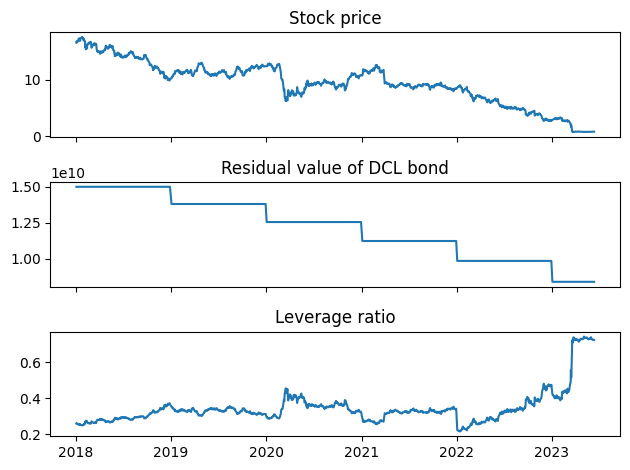

In [18]:
# ================================================================
#                        Plot the results
# ================================================================

def plot_results(df: pd.DataFrame) -> None:
    """
    Plot the results. 
    """

    # plot the closing price, the book value of debt in subplots
    fig, ax = plt.subplots(3, 1, sharex=True)
    ax[0].plot(df.index, df['Close'], label='Close')
    ax[0].set_title('Stock price')
    ax[1].plot(df.index, df['RQ_k'], label='RQ_k')
    ax[1].set_title('Residual value of DCL bond')
    ax[2].plot(df.index, df['Leverage ratio'], label='Leverage ratio')
    ax[2].set_title('Leverage ratio')
    plt.tight_layout()
    plt.show()

plot_results(df_dcl_1)
